# KenKen
Hugo Guillén, 2018.

## Prerrequisitos
Instalar `shapely`

## Archivos de tablero KenKen
El archivo del tablero tiene el siguiente formato:
- Primer línea: dimensión de la matriz (un entero mayor o igual a 3)
- Lineas subsecuentes: las `cages`. Cada `cage` se define por los siguientes valores separados por comas:
 - El primer valor es el resultado al que debe llegar la `cage`.
 - El segundo valor es la operación (`+ - / * =`)
 - Los valores siguientes son las coordenadas de las celdas que conforman la `cage`. Los índices inician en 0. Primero se especifica la fila, después sigue un espacio, y después la columna.

Por ejemplo, para el siguiente tablero:
<img src="example.png" style="width: 200px;"/>

El archivo correspondiente (sin especificar los valores) sería el siguiente:
```
4
8,+,0 0,1 0,1 1
3,=,0 1
16,*,0 2,0 3,1 2,1 3
2,/,2 0, 3 0
1,-,2 1,2 2
3,-,3 1,3 2
2,-,2 3,3 3
```

In [1]:
import sys
import os
from os import path,listdir
import numpy as np
import matplotlib.pyplot as plt
from shapely import geometry, ops

class Cage:
    def __init__(self,n,result,operation,points):
        self.n=n
        self.result=result
        self.operation=operation
        self.points=points
        if operation == '=':
            self.values = [self.result]
        else:
            self.values = [0]*len(points)
                
                
    def __repr__(self):
        return ' '.join(map(str,[self.result,self.operation,self.points,self.values]))

    
    def op_str(self):
        if self.operation == '=':
            return ' '
        if self.operation == '/':
            return '÷'
        if self.operation == '*':
            return '×'
        return self.operation
    
    
    def evaluate(self):
        if min(self.values)==0:
                return False
        if self.operation == '=':
            return self.values[0] == self.result
        if self.operation == '-':
            return (max(self.values)-min(self.values)) == self.result
        if self.operation == '/':            
            return (max(self.values)/min(self.values)) == self.result
        if self.operation == '+':
            return (np.sum(self.values)) == self.result
        if self.operation == '*':
            return (np.prod(self.values)) == self.result 
        
        
    def evaluate2(self):
        if min(self.values)==0:
                return False
        if self.operation == '=':
            return self.values[0]
        if self.operation == '-':
            return (max(self.values)-min(self.values))
        if self.operation == '/':            
            return (max(self.values)/min(self.values))
        if self.operation == '+':
            return (np.sum(self.values))
        if self.operation == '*':
            return (np.prod(self.values))
        
        
class KenkenBoard:
    def __init__(self,cages):        
        self.cages = cages
        self.n = cages[0].n
        
    def __repr__(self):
        return '\n'.join(map(str,self.cages))
    
    def load_solution(self,M):
        self.solution = np.array(M)
        for cage in self.cages:
            for idx,p in enumerate(cage.points):
                cage.values[idx] = self.solution[p[0]][p[1]]
                
    def evaluate(self):
        bad_cages,bad_rows,bad_cols = [],[],[]
        self.solution = np.zeros((self.n,self.n))
        for idx,cage in enumerate(self.cages):            
            if not cage.evaluate():
                bad_cages.append(idx)
            for idx,p in enumerate(cage.points):
                self.solution[p[0]][p[1]] = cage.values[idx]
        for idx,row in enumerate(self.solution):
            if len(set(row)) != self.n:
                bad_rows.append(idx)
        for idx,col in enumerate(self.solution.T):
            if len(set(col)) != self.n:
                bad_cols.append(idx)
        return bad_cages,bad_rows,bad_cols
                
    
def parse_kenken(input_file):
    with open(input_file,'r') as f:
        lines = [l.strip() for l in f.readlines() if len(l.strip())>0]    
    cages = []
    n = int(lines[0])
    for l in lines[1:]:
        args = l.split(',')
        result=int(args[0])
        operation=args[1]
        points = []
        for a in args[2:]:
            points.append(tuple(map(int,a.strip().split(' '))))        
        cage = Cage(n=n,result=result,operation=operation,points=points)
        cages.append(cage)        
    board = KenkenBoard(cages=cages)    
    return board    


def plot_board(board,figsize=(5,5)):
    plt.close('all')
    n = board.n
    fig,ax = plt.subplots(figsize=figsize)
    for cage in board.cages:        
        squares = []
        for p in cage.points:            
            ip = p[::-1]
            squares.append(geometry.box(ip[0],ip[1],ip[0]+1,ip[1]+1))
        shape = ops.cascaded_union(squares)
        xs, ys = shape.exterior.xy        
        ax.plot(xs,ys,linewidth=3,color='black')
        ip = cage.points[0][::-1]
        ax.text(ip[0]+.1,ip[1]+.1,'%s %s'%(cage.result,cage.op_str()),ha='left',va='top')
    ax.set_xticks(range(n+1))
    ax.set_yticks(range(n+1))
    ax.tick_params(labelbottom=False,labelleft=False) 
    plt.xlim(0,n)
    plt.ylim(0,n)    
    plt.ylim(n,0)
    plt.grid(True)
    plt.show()
    
    
def plot_board_solution(board,figsize=(5,5)):
    plt.close('all')
    n = board.n
    fig,ax = plt.subplots(figsize=figsize)
    bad_cages,bad_rows,bad_cols = board.evaluate()
    for cage in board.cages:        
        squares = []
        for idx,p in enumerate(cage.points):
            ip = p[::-1]
            squares.append(geometry.box(ip[0],ip[1],ip[0]+1,ip[1]+1))
            ax.text(ip[0]+.5,ip[1]+.5,'%s'%(cage.values[idx]),ha='center',va='center',size='xx-large')
        shape = ops.cascaded_union(squares)
        xs, ys = shape.exterior.xy
        ax.fill(xs, ys, alpha=0.3, fc= 'g' if cage.evaluate() else 'r', ec='none')
        ax.plot(xs,ys,linewidth=3,color='black')
        ip = cage.points[0][::-1]
        ax.text(ip[0]+.1,ip[1]+.1,'%s %s'%(cage.result,cage.op_str()),ha='left',va='top')
    for row in bad_rows:
        shape = geometry.box(0,row+.3,0.1,row+.7)
        xs, ys = shape.exterior.xy
        ax.fill(xs, ys, alpha=1, fc='r', ec='black')
    for col in bad_cols:
        shape = geometry.box(col+.3,0,col+.7,0.1)
        xs, ys = shape.exterior.xy
        ax.fill(xs, ys, alpha=1, fc='r', ec='black')
    ax.set_xticks(range(n+1))
    ax.set_yticks(range(n+1))
    ax.tick_params(labelbottom=False,labelleft=False) 
    plt.xlim(0,n)    
    plt.ylim(n,0)
    plt.grid(True)
    plt.show()

### Cargar tablero y dibujar

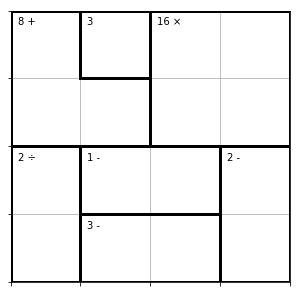

In [2]:
input_file = r'board1.txt'
board = parse_kenken(input_file)
plot_board(board)

### Crear una solución random y evaluarla
La función de evaluación regresa 3 listas: la primera contiene los índices de las `cages` incorrectas, la segunda los índices de las filas incorrectas y la tercera los índices de las columnas incorrectas.

([0, 1, 2, 3, 4, 5], [0, 1, 2, 3], [0, 1, 2, 3])


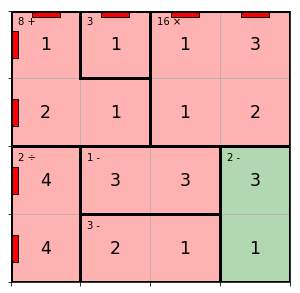

In [3]:
n = board.n
solution_random = np.floor(np.random.rand(n,n)*n+1).astype(int)
board.load_solution(solution_random)
print(board.evaluate())
plot_board_solution(board)

## Cargar una solución completa arbitraria

([1], [2, 3], [2, 3])


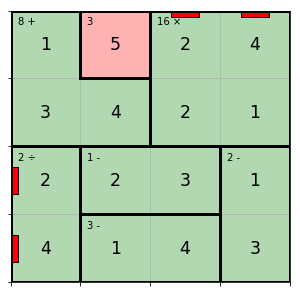

In [4]:
solution_bad = np.array([[1,5,2,4],[3,4,2,1],[2,2,3,1],[4,1,4,3]])
board.load_solution(solution_bad)
print(board.evaluate())
plot_board_solution(board)

Se pueden modificar los valores individuales de los `cages` y el tablero automáticamente registra los cambios.

([], [], [])


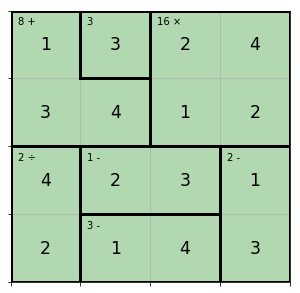

In [5]:
board.cages[1].values=[3]
board.cages[2].values=[2,4,1,2]
board.cages[3].values=[4,2]
print(board.evaluate())
plot_board_solution(board)

In [6]:
import numpy as np
import matplotlib.pyplot as plt

def random_points(N=100):
    return [np.random.rand(2) for i in range(N)]

def plot_points(points,figsize=(6,6),plot_idx=True):
    fig,ax = plt.subplots(figsize=figsize)
    M = np.array(points)    
    plt.scatter(M[:,0],M[:,1],s=100,color='gray',alpha=0.5)
    if plot_idx:
        for idx,p in enumerate(points):
            plt.text(p[0],p[1],str(idx), ha='center',va='center')
    plt.xlabel('$f_1(x)$',fontsize=18)
    plt.ylabel('$f_2(x)$',fontsize=18)
    plt.show()
    
def plot_nondominatedset(points,P,figsize=(6,6)):
    fig,ax = plt.subplots(figsize=figsize)
    nd_mask = np.zeros(len(points), dtype=bool)
    for p in P:
        nd_mask[p]=True
    M = np.array(points)
    M1 = M[np.logical_not(nd_mask),:]
    plt.scatter(M1[:,0],M1[:,1],s=100,color='gray',alpha=0.5)
    M2 = M[nd_mask,:]
    plt.scatter(M2[:,0],M2[:,1],s=100,color='red',alpha=1)
    plt.xlabel('$f_1(x)$',fontsize=18)
    plt.ylabel('$f_2(x)$',fontsize=18)
    plt.show()
    
def plot_nondominatedsort(points,fronts,figsize=(6,6)):
    if len(fronts) == 0:
        return
    fig,ax = plt.subplots(figsize=figsize)    
    for idx,F in enumerate(fronts):
        P = sorted([points[p] for p in F], key=lambda x:(x[0],x[1]))
        M = np.array(P)
        plt.plot(M[:,0],M[:,1],'o-',alpha=0.5)
        for p in F:
            plt.text(points[p][0],points[p][1],str(idx), ha='center',va='center')
    plt.xlabel('$f_1(x)$',fontsize=18)
    plt.ylabel('$f_2(x)$',fontsize=18)
    plt.show()

In [7]:
def dominates(p1,p2):
    return ((p1[0]<=p2[0] and p1[1]<=p2[1]) and (p1[0]<p2[0] or p1[1]<p2[1]))

In [8]:
def nondominatedsort(points):
    n = len(points)
    S = np.zeros(n, dtype=int)
    dominancia = {}
    ###INSERTE SU CÓDIGO AQUÍ
    sets = []
    for i in range(n-1):
        for j in range(i+1,n):
            if dominates(points[i],points[j]):
                S[j]+=1
                if str(i) not in dominancia:
                    dominancia[str(i)] = [j]
                else:
                    dominancia[str(i)].append(j)
            if dominates(points[j],points[i]):
                S[i] +=1
                if str(j) not in dominancia:
                    dominancia[str(j)] = [i]
                else:
                    dominancia[str(j)].append(i)
                
    
    #print(S)
    #print(dominancia)
    #cond = True
    while(True):
        subset = []
        for i in range(len(S)):
            if S[i] == 0:
                subset.append(i)
                S[i] = -999
        
        for e in subset:
            if str(e) in dominancia:
                for ind in dominancia[str(e)]:
                    S[ind] -= 1
        sets.append(subset)
        if max(S) == -999:
            break
        
            
    #print(S)
                
    #print(sets)
            
    
    return sets

In [9]:
def diferenciacages(board):
    suma = 0
    for i in range(len(board.cages)):
        dif = board.cages[i].evaluate2() - board.cages[i].result
        if dif<0:
            dif*=-1
        suma += dif
    return suma

7
1
72
1.3333333333333333
2
3
0
[[6, 3], 0]
[[62.666666666666664, 3], 0]


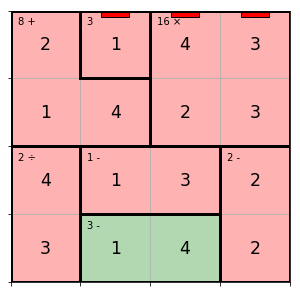

In [22]:
import itertools
from sympy.utilities.iterables import multiset_permutations
import random as rand

input_file = r'board1.txt'
board = parse_kenken(input_file)
n = board.n
arreglo = np.array([1,2,3,4])
permutaciones = [p for p in multiset_permutations(arreglo)]
solution_random = [permutaciones[rand.randint(0,len(permutaciones)-1)] for i in range(n)]
#print(solution_random)
board.load_solution(solution_random)
#print(board)
#print(board.cages[2])
suma = 0
for i in range(len(board.cages)):
    print(board.cages[i].evaluate2())
    dif = board.cages[i].evaluate2() - board.cages[i].result
    if dif<0:
        dif*=-1
    suma += dif
#print(board.cages[2].evaluate())


frente = [[len(board.evaluate()[0]),len(board.evaluate()[2])],0]
frente2 = [[diferenciacages(board),len(board.evaluate()[2])],0]
print(frente)
print(frente2)
plot_board_solution(board)

[[[12, 4], 0], [[40, 3], 1], [[36, 4], 2], [[3, 4], 3], [[13, 4], 4], [[11, 4], 5], [[14, 4], 6], [[5, 4], 7], [[16, 4], 8], [[9, 4], 9], [[7, 3], 10], [[14, 4], 11], [[11, 2], 12], [[40, 4], 13], [[9, 4], 14], [[15, 4], 15], [[61, 4], 16], [[5, 4], 17], [[16, 3], 18], [[14, 4], 19], [[3, 2], 20], [[16, 3], 21], [[14, 4], 22], [[12, 3], 23], [[25, 4], 24], [[4, 4], 25], [[53, 3], 26], [[54, 3], 27], [[24, 4], 28], [[25, 3], 29], [[136, 3], 30], [[14, 3], 31], [[13, 3], 32], [[39, 4], 33], [[21, 2], 34], [[6, 2], 35], [[64, 4], 36], [[23, 4], 37], [[87, 4], 38], [[10, 3], 39], [[10, 4], 40], [[11, 4], 41], [[20, 3], 42], [[2, 4], 43], [[39, 4], 44], [[25, 3], 45], [[16, 4], 46], [[40, 3], 47], [[29, 4], 48], [[87, 4], 49], [[4, 4], 50], [[9, 4], 51], [[9, 3], 52], [[10, 4], 53], [[27, 3], 54], [[12, 3], 55], [[9, 4], 56], [[58, 3], 57], [[29, 4], 58], [[20, 3], 59]]
#####################################
[[12, 4], [40, 3], [36, 4], [3, 4], [13, 4], [11, 4], [14, 4], [5, 4], [16, 4], [9, 

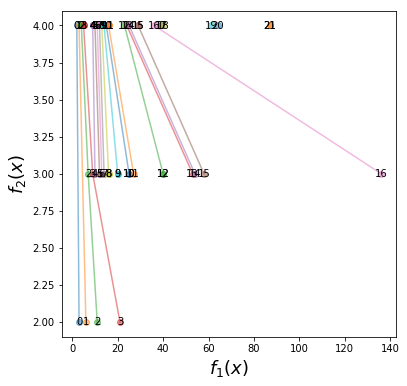

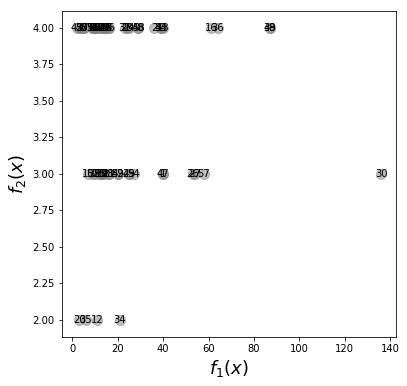

In [41]:
N = 60  # tamaño de la poblacion
pM = .9  # probabilidad de mutacion
i = 0  # contador de generaciones
G = 120  # Numero de generaciones

poblacion = [parse_kenken(input_file) for i in range(N)]
for tablero in poblacion:
    solucion_random = []
    ind_ant = rand.randint(0,len(permutaciones)-1)
    for _ in range(n):
        ind_act = rand.randint(0,len(permutaciones)-1)
        while(ind_act == ind_ant):
            ind_act = rand.randint(0,len(permutaciones)-1) 
        solucion_random.append(permutaciones[ind_act])
        ind_ant = ind_act
        
    tablero.load_solution(solucion_random)
    #print(tablero.evaluate())
    #plot_board_solution(tablero)
    ##objetivos
    ##1. la suma de las diferencias de resultados de cada cage
    ##2. el numero de columnas incorrectas
 

#frente = [[[len(poblacion[i].evaluate()[0]),len(poblacion[i].evaluate()[2])],i] for i in range(N)]
frente2 = [[[int(diferenciacages(poblacion[i])),len(poblacion[i].evaluate()[2])],i] for i in range(N)]
#frente2 = [[[diferenciacages(poblacion[i]),len(poblacion[i].evaluate()[2])],i] for i in range(N)]
#print(frente)
print(frente2)

board = poblacion[0]
#print(board)
print("#####################################")
points = [e[0] for e in frente2]
print(points)
print("QWERTYQWERTYQWERTYQWERTYQWERTYQWERTYQWERTY")
sets = nondominatedsort(points)
for s in sets:
    print(s)
plot_nondominatedsort(points,sets)
plot_points(points)
##([cages incorrectas],[indices de filas incorrectas],[indices de columnas incorrectas])
while(i<G):
    i += 1
    

    

In [35]:
print(rand.uniform(.3,.7))

0.38625124618480344
